<a href="https://colab.research.google.com/github/lordachita/MNIST_without_conv/blob/main/01_Two_Layers_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Universal Approximation Property

  We provide the most recognizable version of the **Universal Approximation Property** for neural networks from Pinkus [1]. This property ensures that any **continuous** function can be estimated by a single two layers neural network, with arbitrary width in the first layer. The statement can be written mathematically as below

---

[Pinkus 1999] \\
**Theorem 3.1** 
Let $\sigma \in \mathcal{C}(\mathbb{R})$ and $\mathcal{M}(\sigma) = span \{\sigma(w^Tx-b) \colon w\in\mathbb{R}^n, b\in\mathbb{R}\}$ \\
Then $\mathcal{M}(\sigma)$ is dense in $\mathcal{C}(\mathbb{R}^n)$, in the topology of uniform convergence on compacta, if and only if \\
$\sigma$ is **not a polynomial**.

---

Fortunately, this statement can be written in a more readable format as follow:

For any target function $f: \mathbb{R}^d \rightarrow \mathbb{R}$, \\
// *which is continuous* \\
every compact subset $K$ of $\mathbb{R}^d$, \\
// *e.g. an n-dimensional box $K = [0,1]^n$ is compact* \\
there exists a neural network $f_\epsilon : \mathbb{R}^d \rightarrow \mathbb{R}$ of form $f_\epsilon (x) = W_2 (\sigma (W_1x-b_1))$ \\
// *in this case, $W_1 \in \mathbb{R}^{N \times d}$, $b_1\in \mathbb{R}^{N}$,   $\sigma$ acts componentwise, $W_2 \in \mathbb{R}^{1 \times N}$* \\
// *the quality of approximation depends on N, as you will see below* \\
such that for any small $\epsilon > 0$ and \\
for $x \in K$ , $ | f(x) - f_\epsilon (x) | < \epsilon$, \\
// *this is an mathematical implementation for approximation, \\
i.e. the difference of $f(x)$ and $f_\epsilon (x)$ for any $x$ have a difference less than $\epsilon$.* \\
// *this can be written equivalent as $\sup_{x \in K} | f(x) - f_\epsilon (x) | < \epsilon$*


if and only if an activation function $\sigma:\mathbb{R} \rightarrow \mathbb{R}$ is **not a polynomial**. \\
// *the activation function has to be continuous*.

Therefore, there are two main conditions of using two layers neural network for classification tasks: 
1. The target function is continuous. 
2. The activation function is non-polynomial.

In fact, a continuous property is too strong. For instance, theorems in optimization usually require a weaker form of continuity so called lower semicontinuous. In addition, a classification task itself is to find the target function, without knowing the function in advance. 


The property is also hold for multilabels classifications, $f: \mathbb{R}^d \rightarrow \mathbb{R}^D$, since the function $f$ can be written as $f(x) = (f_1(x),...,f_D(x))$ where $f_i(x): \mathbb{R}^d \rightarrow \mathbb{R}$. That is $f$ can be approximated from each $f_i$, provided that $f$ is continuous (this implies that each component $f_i$ of $f$ is also continuous). For MNIST dataset, we set up our feature vector to $d = 784 = 28 \times 28$ and the number of output neurons to $D = 10$. 

**Hence, our objective for MNIST classification using two layers neural network is to find the most suitable N which gives the best approximation of target function.**

In [ ]:
# Implementing Matrix
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

In [ ]:
# Download MNIST dataset

(X_train, y_train), (X_test, y_test) = mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


### Models

In [ ]:
# We build a Neural Network with Keras
def build_model(n_dim = [100]):
  
  # Define an input of the model
  inputs = Input(shape=(28,28))

  # Flatten the input matrix into a single array
  x = Flatten()(inputs)

  # Our implementation allows to deepen the model later 
  for i in range(len(n_dim)):

    # Create a linear layer W1 with n_dim[i] output neurons
    # An activation \sigma has to be non-polynomial as stated in the property
    x = Dense(n_dim[i], activation='relu')(x)

  # Define the output of the model, with 10 output neurons
  outputs = Dense(10, activation='softmax')(x)

  # Define the model by giving the input and output
  model = Model(inputs=inputs, outputs=outputs)
   
  # Define optimizer, loss and evaluation metric
  model.compile(
      optimizer="adam", 
      loss="sparse_categorical_crossentropy", 
      metrics=["accuracy"]
      )

  # We can observe the model parameters from summary()
  model.summary()

  return model

In [ ]:
# Training
epochs = 30 # @param {type: "slider", min:10, max:100}
n_train = 3 # @param {type: "slider", min:1, max:20}
n_dim_domain = [10, 50, 100, 200, 500, 1000]

val_accuracy = {}

# Test our model with various layer widths in order to find the most suitable one
# In this case, we use a grid-search strategy
for size in n_dim_domain:

  val_acc = []

  # Test the model multiple times in order to observe the sensitivity of each variant
  for _ in range(n_train):

    model = build_model(n_dim = [size])

    hist = model.fit(X_train, y_train,
                     epochs = epochs,
                     validation_data = (X_test, y_test), 
                     verbose = 1)
    
    # We only collect the maximum accuracy from each training
    val_acc.append(max(hist.history["val_accuracy"]))

  val_accuracy[size] = val_acc

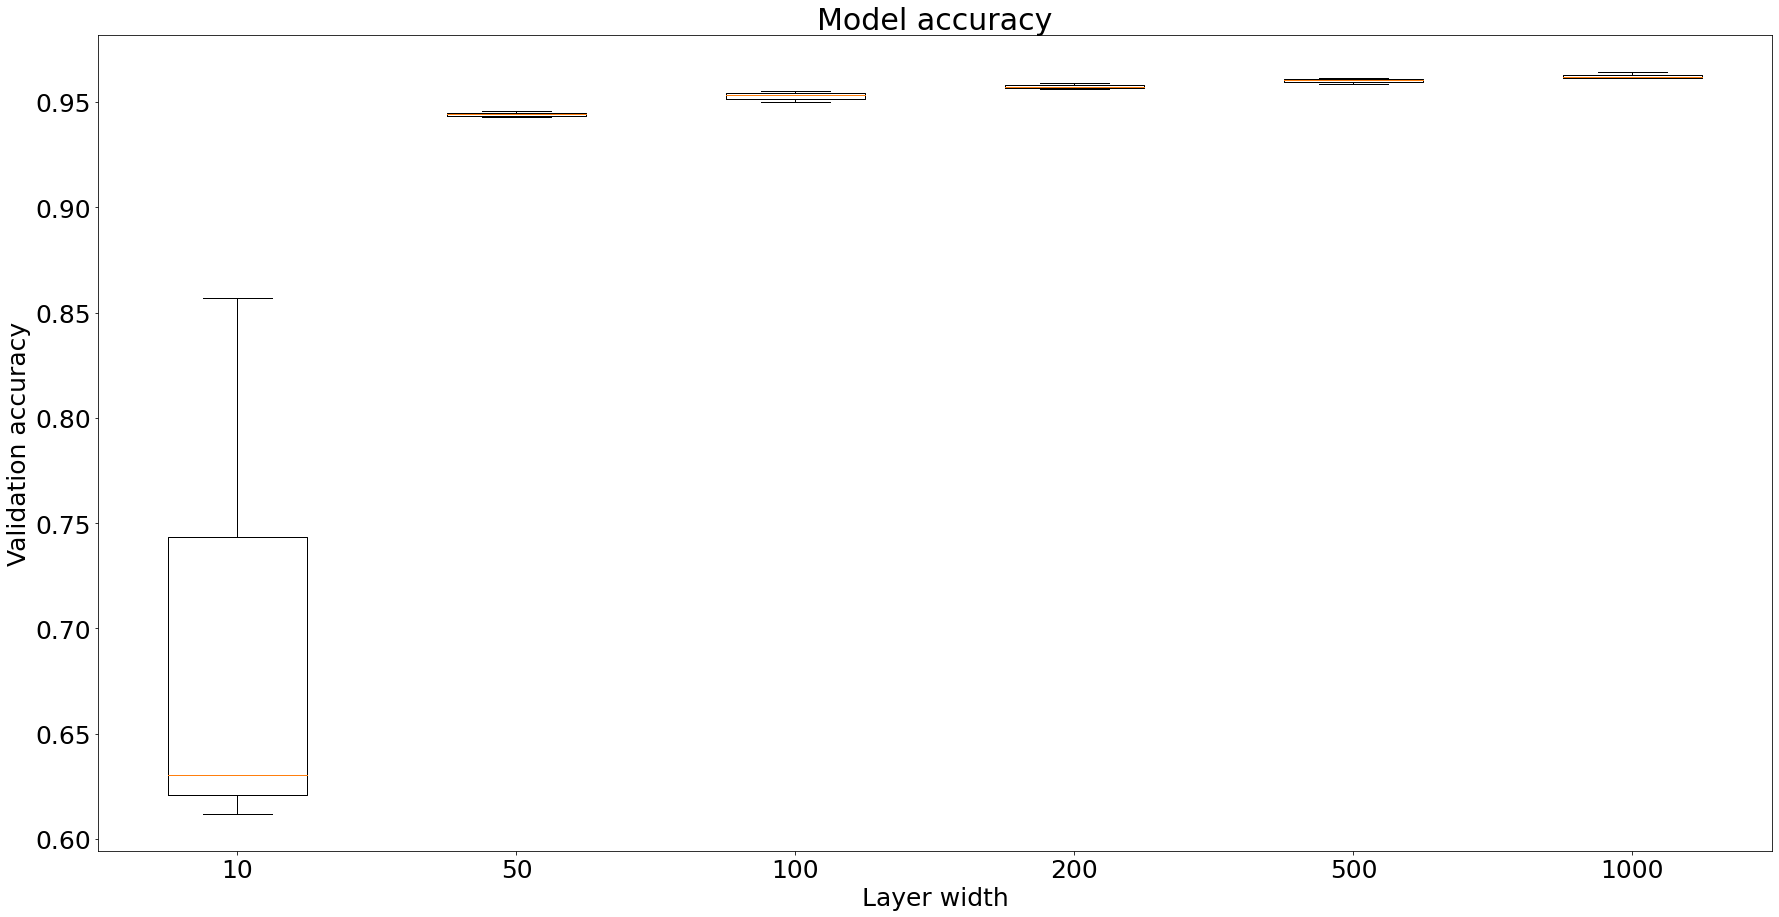

In [ ]:
# Plot 
plt.figure(figsize=(30,15))
plt.rc('font', size = 25) 

plt.boxplot([val_accuracy[n] for n in n_dim_domain], 
            labels = n_dim_domain)

plt.title("Model accuracy")
plt.ylabel("Validation accuracy")
plt.xlabel("Layer width")

plt.show()

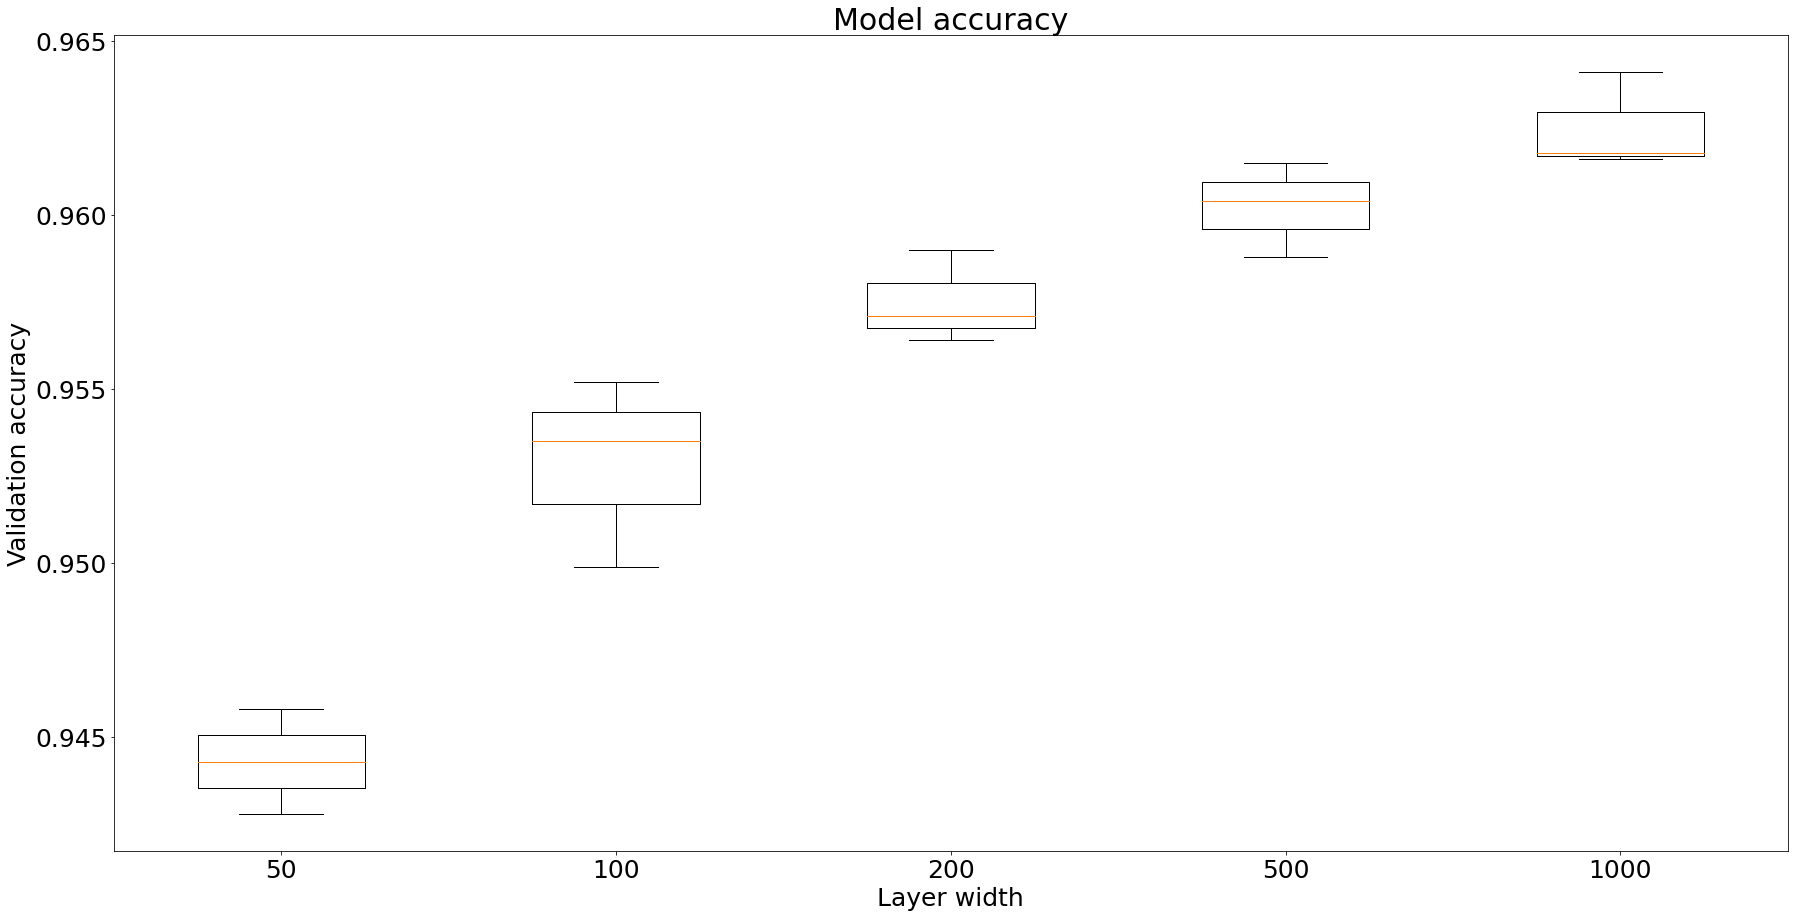

In [ ]:
# Plot 
plt.figure(figsize=(30,15))
plt.rc('font', size = 25) 

plt.boxplot([val_accuracy[n] for n in n_dim_domain][1:], 
            labels = n_dim_domain[1:])

plt.title("Model accuracy")
plt.ylabel("Validation accuracy")
plt.xlabel("Layer width")

plt.show()

### Hyperparameter optimization

In this section, we let the algorithm [2] determines the most suitable hyperparameters for us. 

In [ ]:
# Install the package

pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=bf354e3ccecf8f2da1a24e0bb780cb4b0c1c51480cd86cdb13f2a7e2746205a1
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=ed616233a4a5e5f908ef6deaa9ec13e39bb657c1d462d4e320443feea8460c6a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# Hyperparameter Optimization
import kerastuner as kt

In [ ]:
# In this step, we use hp instead of n_dim
def build_model_(hp):

  inputs = Input(shape=(28,28))

  x = Flatten()(inputs)

  for i in range(1):
    # In this step, we add hp.Int for hyperparameters optimization
    x = Dense(hp.Int('dense', min_value=10, max_value=1000, step=10), activation='relu')(x)

  outputs = Dense(10, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(
      optimizer="adam", 
      loss="sparse_categorical_crossentropy", 
      metrics=["accuracy"]
      )

  return model

In [ ]:
tuner = kt.Hyperband(build_model_, objective='val_accuracy', max_epochs = 30)

In [ ]:
tuner.search(X_train, y_train,
             validation_data = (X_test, y_test),
             epochs = 30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 90 Complete [00h 00m 14s]
val_accuracy: 0.939300000667572

Best val_accuracy So Far: 0.9502999782562256
Total elapsed time: 00h 14m 11s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Obtain the model with best accuracy
best_model = tuner.get_best_models(1)[0]

In [ ]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


### Confusion Matrix

A confusion matrix can be used to observe a prediction behavior of the model.
For instance, we could observe labels that the model tends to predict. We select a heatmap for a visualization of the confusion matrix.

In [ ]:
# Plot
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
predictions = np.array([])
labels =  np.array([])

for i in range(100):
    predictions = np.concatenate([predictions, np.argmax(best_model.predict(X_test[100*i : 100*(i+1), :, :]), axis=-1)])
    labels = np.concatenate([labels, y_test[100*i : 100*(i+1)]])

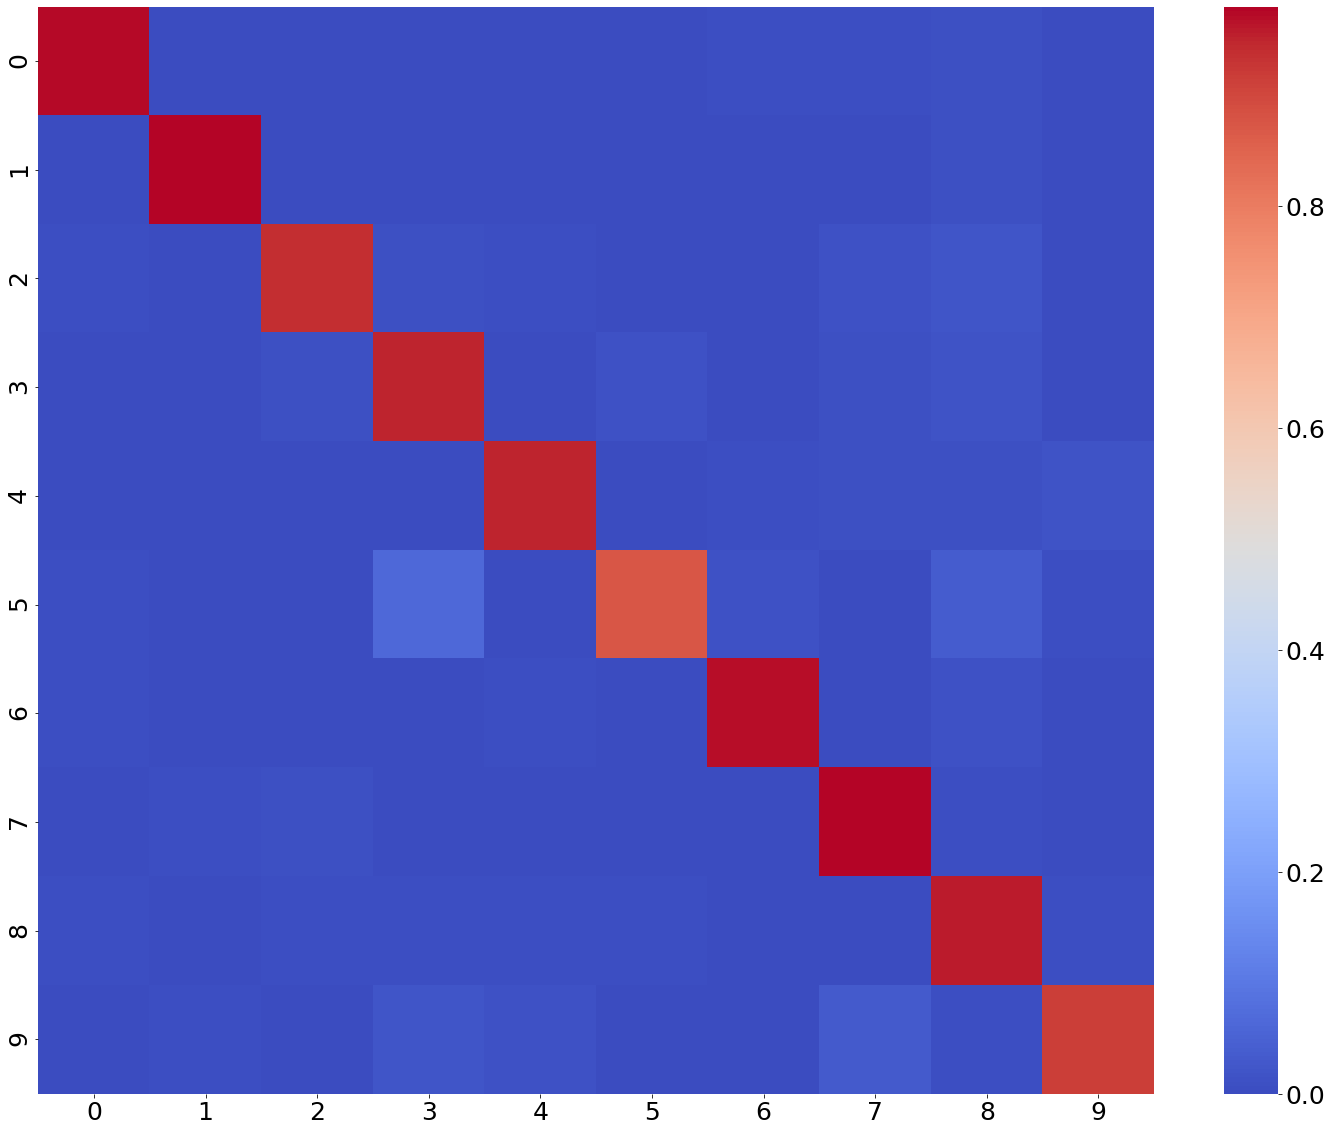

In [ ]:
plt.figure(figsize=(25,20))
confusion_mat = confusion_matrix(labels, predictions, normalize = 'true')
sns.heatmap(confusion_mat, cmap = sns.color_palette("coolwarm", as_cmap=True))

We observe that among the incorrect predictions, our model is likely to predict images as eights. In addition, the model seems to struggle with predicting fives than other numbers. We will see what we could further improve in a few slides.

Reference: \\
[0] https://www.youtube.com/watch?v=lkha188L4Gs \\
[1] https://pinkus.net.technion.ac.il/files/2021/02/acta.pdf \\
[2] https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html